# Barotropic Streamfunction in MOM5/MOM6

The barotropic streamfunction ($\psi$) is obtained from the integration of the velocity field starting from a physical boundary at which we know the transport is zero. The difference between to streamlines is a measure of the transport between them. 

There are different ways to calculate it depending on your choice of boundary for the integration. This notebook calculates it integrating in the meridional space, starting from the Antarctic continent using the zonal velocity field:

$$
\psi = \int_{y_{\rm Antarctica}}^{y} U \, \mathrm{d}y ,
$$

where $U = \int u \, \mathrm{dz}$ is the depth-integrated $u$-velocity.

In [1]:
import cartopy.crs as ccrs
import pandas as pd
import cartopy.feature as cfeature
import cf_xarray as cfxr
import intake
catalog = intake.cat.access_nri
import cmocean
import dask.distributed as dask
import glob
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Initialise a dask client

In [2]:
client = dask.Client("tcp://10.6.24.31:8786")
client

<Client: 'tcp://10.6.24.31:8786' processes=1 threads=12, memory=46.00 GiB>

Load a session to access the COSIMA database

The dictionary below specifies experiment, start and ending times for each model we can use (MOM5 or MOM6). 

If you want a different experiment, or a different time period, change the necessary values. A tutorial on how to explore the database for available experiments is available [here](https://github.com/COSIMA/cosima-recipes/blob/master/Tutorials/COSIMA_CookBook_Tutorial.ipynb)

In [3]:
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "variable": "tx_trans_int_z",
                       "start_time": "2035-01-01",
                       "end_time": "2055-01-01",
                      "frequency": '1mon'},

              # "mom6": {"expt": "panant-01-zstar-v13",
              #          "variable": "umo_2d",
              #          "start_time": "2035-01-01",
              #          "end_time": "2050-01-01",
              #          "frequency": '1mon'}
             }

## Functions to load data

The functions below will load the necessary data, and calculate the barotropic streamfunction

In [4]:
# Define a reference density
RHO_0 = 1035 # kg/m^3

def load_zonal_transport(model):
    # Model can be set to 'mom5' or 'mom6'
    
    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]
    variable = model_args[model]['variable']
    frequency=model_args[model]['frequency']

    cat_subset = catalog[experiment]
    var_search = cat_subset.search(variable=variable, frequency=frequency)
    darray = var_search.to_dask()
    darray = darray[variable]
    transport = darray
    
    # ensure we get the time-slice we wanted
    transport = transport.sel(time = slice(start_time, end_time))
    
    return transport

def calculate_streamfunction(model):
    # Transport is the output from load_zonal_transport(model) function above
    # Model can be set to 'mom5' or 'mom6'
    
    ψ = transport[model].cf.cumsum('latitude')
    # Divide by reference density (RHO_0) in order to get volume transport
    ψ = ψ / RHO_0
    # Divide by 1e6 to get units in Sv
    ψ = ψ / 1e6
    
    #Set attributes
    ψ = ψ.rename('psi')
    ψ.attrs['units'] = 'Sv'
    ψ.attrs['Standard name'] = 'Barotropic streamfunction'
    
    return ψ

## Plotting functions

We can define our plotting functions before and call them later on

In [5]:
def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -40], crs=ccrs.PlateCarree())

    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Add land features and gridlines
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
                   facecolor = 'gainsboro'), zorder = 2)
    
    return fig, ax

def shift_colormap(cmap, min_val, max_val, name):

    import matplotlib as mpl
    import matplotlib.colors as mcolors

    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val)
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint = False), 
                             np.linspace(midpoint, 1, 129, endpoint = True)])
    
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) 
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = mcolors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap = newcmap)

    return newcmap

# Calculate barotropic streamfunction ($\psi$) and plot 

Let's load the transports. We store them in a dictionary. We can use a `for`-loop to load for every model, e.g.,

In [6]:
transport = {}
for model in model_args:
    transport[model] = load_zonal_transport(model)

Now we compute the streamfunction from the transport. We showcase how `for`-loop can be avoided in this simple case that we are only looping over two models.

In [7]:
ψ = {}
for model in model_args:
    ψ[model] = calculate_streamfunction(model)


Calculate the time-mean and plot.

In [8]:
ψ_mean = {}
for model in model_args:
    ψ_mean[model] = ψ[model].cf.mean('time').load()

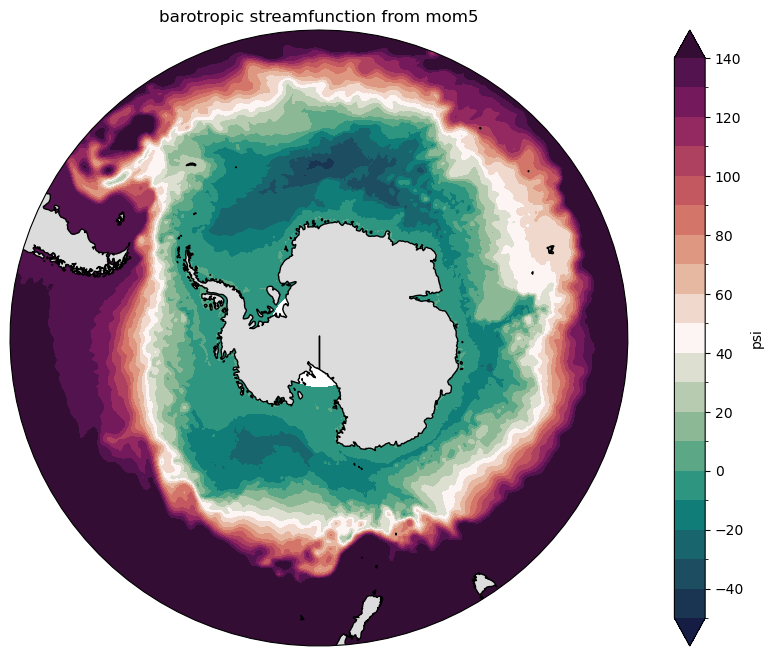

In [9]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 150, 10)

# Plot the barotropic stream function
ψ_mean['mom5'].cf.plot.contourf(ax = ax,
                                x = 'longitude', y = 'latitude', 
                                transform = ccrs.PlateCarree(),
                                levels = levels, extend = 'both',
                                cmap = cmocean.cm.curl)

plt.title('barotropic streamfunction from mom5');

KeyError: 'mom6'

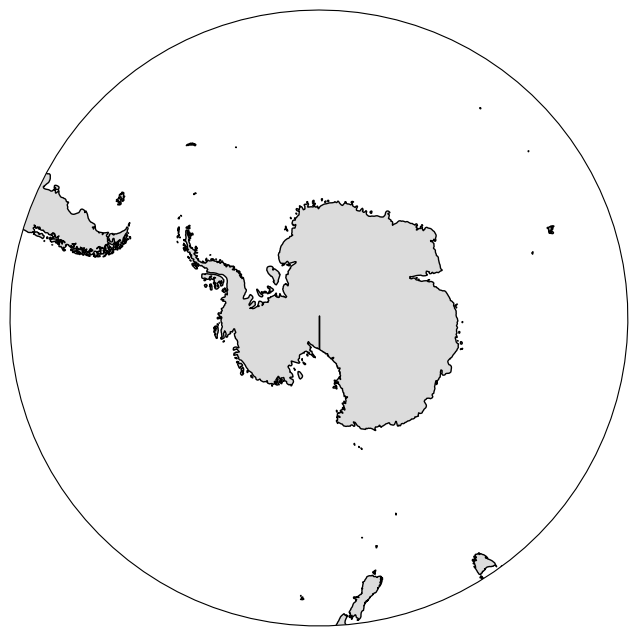

In [10]:
fig, ax = circumpolar_map()

# Define the levels for the contourf
levels = np.arange(-50, 150, 10)

# Plot the barotropic stream function
ψ_mean['mom6'].cf.plot.contourf(ax = ax,
                                x = 'longitude', y = 'latitude', 
                                transform = ccrs.PlateCarree(),
                                levels = levels, extend = 'both',
                                cmap = cmocean.cm.curl)

plt.title('barotropic streamfunction from mom6');